In [1]:
pip install plotly_express

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

plt.rcParams['image.cmap'] = "Dark2"
import plotly_express as px
from scipy.stats import iqr
from scipy.cluster import hierarchy
import random
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.base import BaseEstimator,TransformerMixin#自作の特徴量変換器を作る基礎
from sklearn.pipeline import make_pipeline,Pipeline#処理フローを一つにまとめる
from sklearn.feature_selection import (mutual_info_regression,#特徴量の重要度計算（非線形）
                                       SequentialFeatureSelector as sk_sfs)#特徴量の組み合わせを最適化
from sklearn.model_selection import (train_test_split,GridSearchCV,RandomizedSearchCV,#ハイパーパラメータ探索
                                     RepeatedKFold,RepeatedStratifiedKFold,KFold,#精度検証のための分割方法
                                     StratifiedKFold,cross_val_score)

In [4]:
from sklearn.ensemble import RandomForestRegressor,VotingRegressor,GradientBoostingRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool
from sklearn.neighbors import KNeighborsRegressor

In [5]:
from sklearn.preprocessing import (MaxAbsScaler,MinMaxScaler,Normalizer,
                                   PowerTransformer,QuantileTransformer,RobustScaler,StandardScaler,
                                   minmax_scale,LabelEncoder,OneHotEncoder,FunctionTransformer)


In [6]:
import lightgbm as lgb 
from sklearn.decomposition import PCA,NMF
from sklearn.metrics import (confusion_matrix,make_scorer,mean_squared_error,
                             r2_score,mean_squared_log_error)

In [7]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE, chi2

In [8]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

In [9]:
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, cv

In [10]:
pip install umap

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [12]:
from collections import Counter
import umap
import optuna
from optuna.samplers import TPESampler

In [13]:
facecolor = '#080808'
chartcolor = '#deb887'

In [14]:
train_raw = pd.read_csv('playground-series-s5e5/train.csv',index_col='id')
test_raw = pd.read_csv('playground-series-s5e5/test.csv',index_col='id')
sample_submission = pd.read_csv('playground-series-s5e5/sample_submission.csv')

target = 'Calories'
train_raw.head(3)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0


In [15]:
print(train_raw["Heart_Rate"].max())

128.0


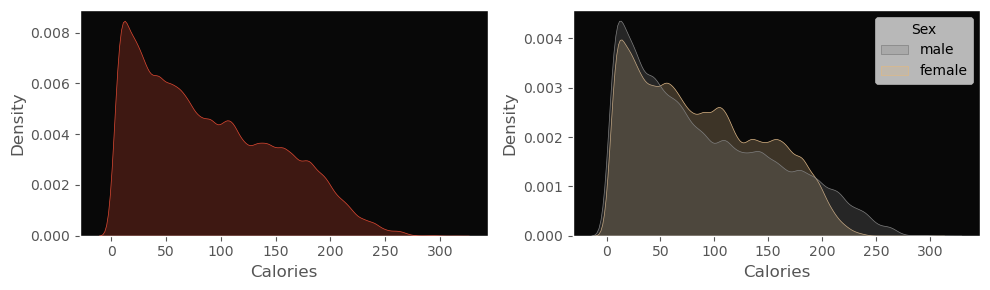

In [16]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
ax_1 = sns.kdeplot(train_raw,x=target,fill=True,palette=plt.cm.Set3)
ax_1.set_facecolor(facecolor)
ax_1.grid(False)
plt.subplot(1,2,2)
ax_2 = sns.kdeplot(train_raw,x=target,hue='Sex',fill=True,palette=['grey',chartcolor])
ax_2.set_facecolor(facecolor)
ax_2.grid(False)
plt.tight_layout()

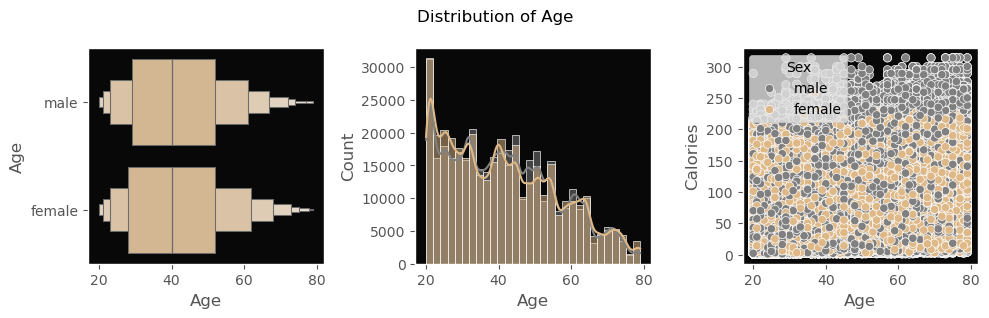

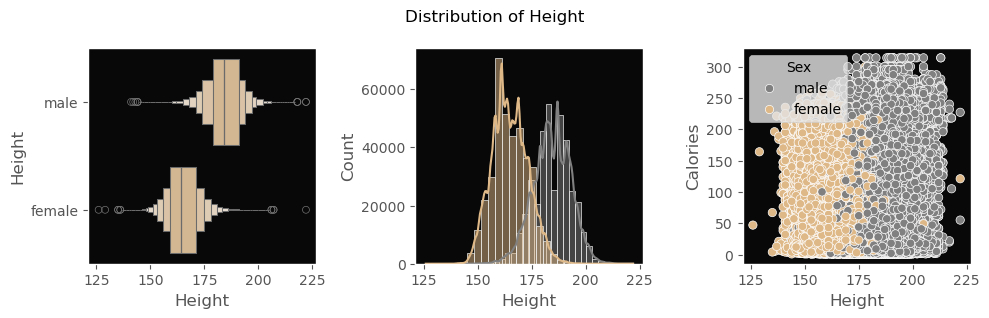

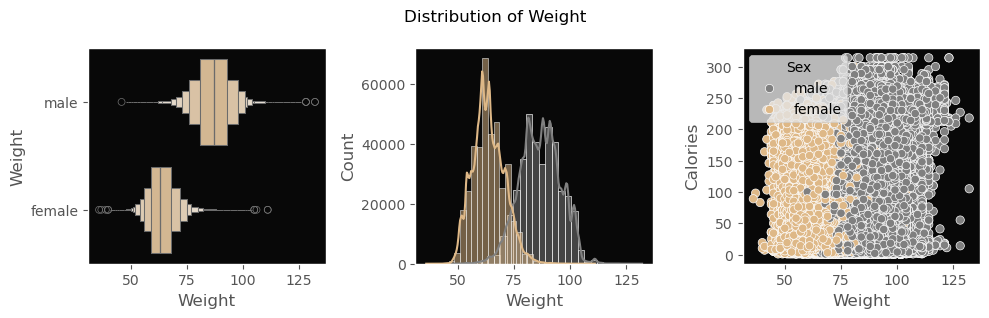

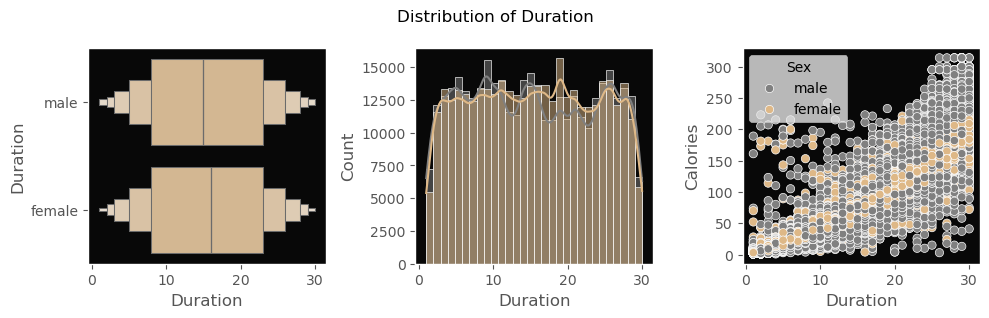

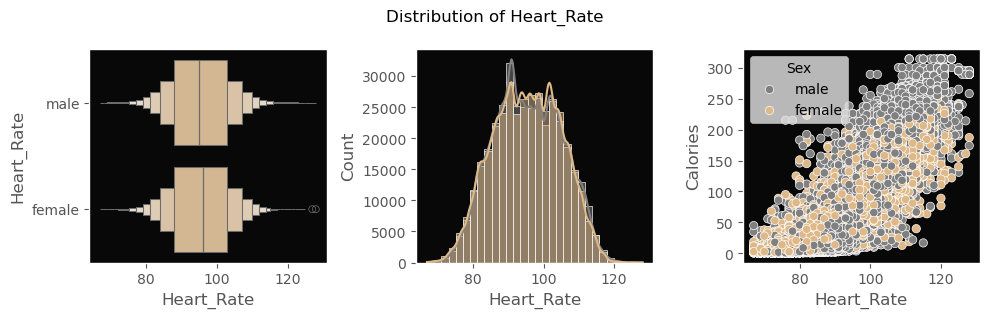

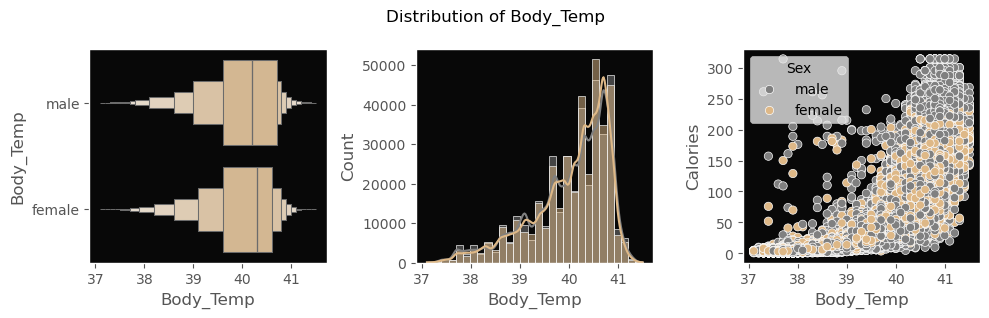

In [17]:
for feat in train_raw.columns.tolist()[1:-1]:
    plt.figure(figsize=(10,3.2))
    plt.subplot(1,3,1)
    ax_1 = sns.boxenplot(train_raw,x=feat,y='Sex',color=chartcolor)
    ax_1.set_facecolor(facecolor)
    ax_1.grid(False)
    plt.ylabel(feat)
    plt.subplot(1,3,2)
    ax_2 = sns.histplot(train_raw[train_raw['Sex']=='male'][feat],color='grey',bins=30,kde=True)
    ax_2 = sns.histplot(train_raw[train_raw['Sex']=='female'][feat],color=chartcolor,bins=30,kde=True)
    ax_2.set_facecolor(facecolor)
    ax_2.grid(False)
    plt.subplot(1,3,3)
    ax_3 = sns.scatterplot(train_raw,x=feat,y=target,hue='Sex',palette=['grey',chartcolor])
    ax_3.set_facecolor(facecolor)
    ax_3.grid(False)
    plt.suptitle(f'Distribution of {feat}')
    plt.tight_layout()

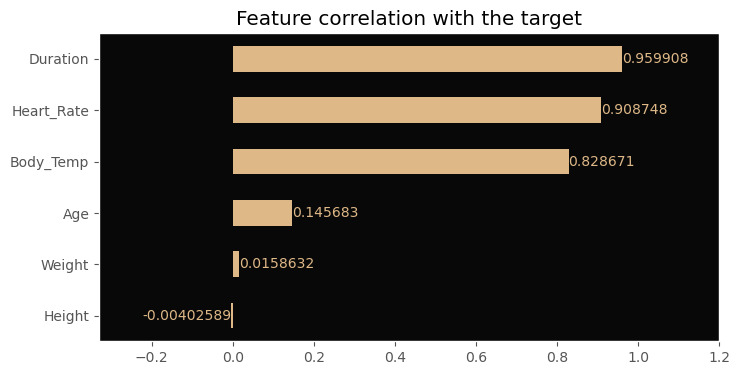

In [18]:
train_data = train_raw.copy()
train_target = train_data.pop(target)

plt.figure(figsize=(8,4))#.corrwith()はSeries*DataFrame(Series)
ax = train_data.iloc[:,1:].corrwith(train_target).sort_values(
    ascending=True).plot.barh(color=chartcolor,title='Feature correlation with the target')
plt.xlim([-0.33,1.2])
ax.set_facecolor(facecolor)
ax.grid(False)
for label in ax.containers:
    ax.bar_label(label,color=chartcolor,fontsize=10)
plt.show()

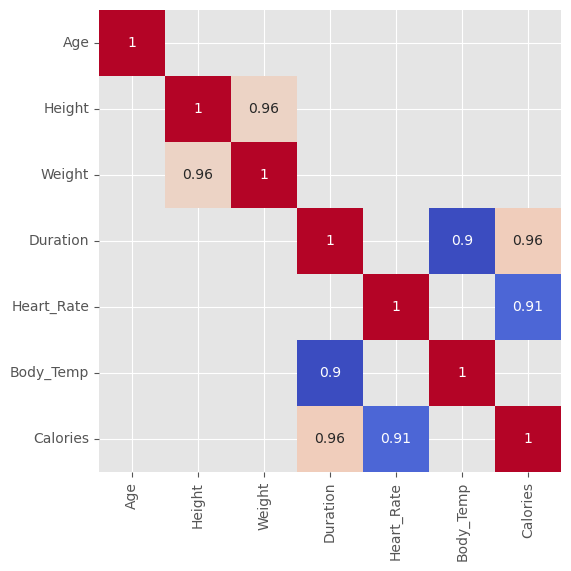

In [19]:
corr = train_raw.corr(numeric_only=True).abs()

corr_selected = corr.mask(((corr<0.9)|(corr>1)),float("NaN"))
plt.figure(figsize=(8,6))
sns.heatmap(corr_selected,cmap='coolwarm',cbar=False,annot=True,square=True)
plt.show()

In [20]:
#Data Preprocessing
create_new_features = True

def featEng(df):
    if create_new_features:
        df["Max_heart_rate"] = 207 -0.7*df["Age"]
        df["%_heart_rate"] = df["Heart_Rate"]/df["Max_heart_rate"]
        df["heart_rate_/_weight"] = df["Heart_Rate"]/df["Weight"]
        df["heart_rate_/_Age"] = df["Heart_Rate"]/df["Age"]
        df["Heart_Rate_x_Duration"] = df["Heart_Rate"]*df["Duration"]
        df["Heart_Rate_x_Duration__log"] = np.log1p(df["Heart_Rate"]*df["Duration"])
        df["bmi"] = df["Weight"]/(0.01*df["Height"])**2
        df["log_weight_x_height"] = np.log(df["Weight"]*df["Height"])
        df["body_temp_x_weight"] = df["Body_Temp"]*np.log(df["Weight"])
        df["Body_Temp-37"] = df["Body_Temp"]-37
        df["heat"] = df["Weight"]*df["Body_Temp-37"]
        df["work"] = df["heat"]*df["Duration"]/60
        df["Sex"] = (df["Sex"]=="female")*1
        df = df.drop(columns=["Duration"])
    else:
        df["Sex"] = (df["Sex"]=="female")*1
        df["Heart_Rate_x_Duration__log"] = np.log1p(df["Heart_Rate"]*df["Duration"])
        df = df.drop(columns=["Duration"])
    return df

In [21]:
def DataTargetPrep(df):
    data_ = df.copy()
    data_ = featEng(data_)
    try:
        target_ = data_.pop(target)
        target_log = np.log1p(target_)
    except:
        pass

    try:
        return data_,target_,target_log
    except:
        return data_

In [22]:
train_prep = train_raw.copy()
X_train_prep,y_train,y_train_log = DataTargetPrep(train_prep)
test_prep = test_raw.copy()
X_test_prep = DataTargetPrep(test_prep)

In [23]:
X_train_prep.head(5)

,Sex,Age,Height,Weight,Heart_Rate,Body_Temp,Max_heart_rate,%_heart_rate,heart_rate_/_weight,heart_rate_/_Age,Heart_Rate_x_Duration,Heart_Rate_x_Duration__log,bmi,log_weight_x_height,body_temp_x_weight,Body_Temp-37,heat,work
id,,,,,,,,,,,,,,,,,,
0,0,36,189.0,82.0,101.0,41.0,181.8,0.555556,1.231707,2.805556,2626.0,7.873598,22.955684,9.648466,180.675489,4.0,328.0,142.133333
1,1,64,163.0,60.0,85.0,39.7,162.2,0.524044,1.416667,1.328125,680.0,6.523562,22.582709,9.188095,162.545479,2.7,162.0,21.600000
2,1,51,161.0,64.0,84.0,39.8,171.3,0.490368,1.312500,1.647059,588.0,6.378426,24.690405,9.240287,165.523547,2.8,179.2,20.906667
3,0,20,192.0,90.0,105.0,40.7,193.0,0.544041,1.166667,5.250000,2625.0,7.873217,24.414062,9.757305,183.142254,3.7,333.0,138.750000
4,1,38,166.0,61.0,102.0,40.6,180.4,0.565410,1.672131,2.684211,2550.0,7.844241,22.136740,9.222862,166.901479,3.6,219.6,91.500000


In [24]:
X_test_prep.head(5)

,Sex,Age,Height,Weight,Heart_Rate,Body_Temp,Max_heart_rate,%_heart_rate,heart_rate_/_weight,heart_rate_/_Age,Heart_Rate_x_Duration,Heart_Rate_x_Duration__log,bmi,log_weight_x_height,body_temp_x_weight,Body_Temp-37,heat,work
id,,,,,,,,,,,,,,,,,,
750000,0,45,177.0,81.0,87.0,39.8,175.5,0.495726,1.074074,1.933333,609.0,6.413459,25.854639,9.570599,174.899076,2.8,226.8,26.460000
750001,0,26,200.0,97.0,101.0,40.5,188.8,0.534958,1.041237,3.884615,2020.0,7.611348,24.250000,9.873028,185.275795,3.5,339.5,113.166667
750002,1,29,188.0,85.0,102.0,40.4,186.7,0.546331,1.200000,3.517241,1632.0,7.398174,24.049344,9.679093,179.483111,3.4,289.0,77.066667
750003,1,39,172.0,73.0,107.0,40.6,179.7,0.595437,1.465753,2.743590,2140.0,7.669028,24.675500,9.437954,174.192653,3.6,262.8,87.600000
750004,1,30,173.0,67.0,94.0,40.5,186.0,0.505376,1.402985,3.133333,1504.0,7.316548,22.386314,9.357984,170.290051,3.5,234.5,62.533333


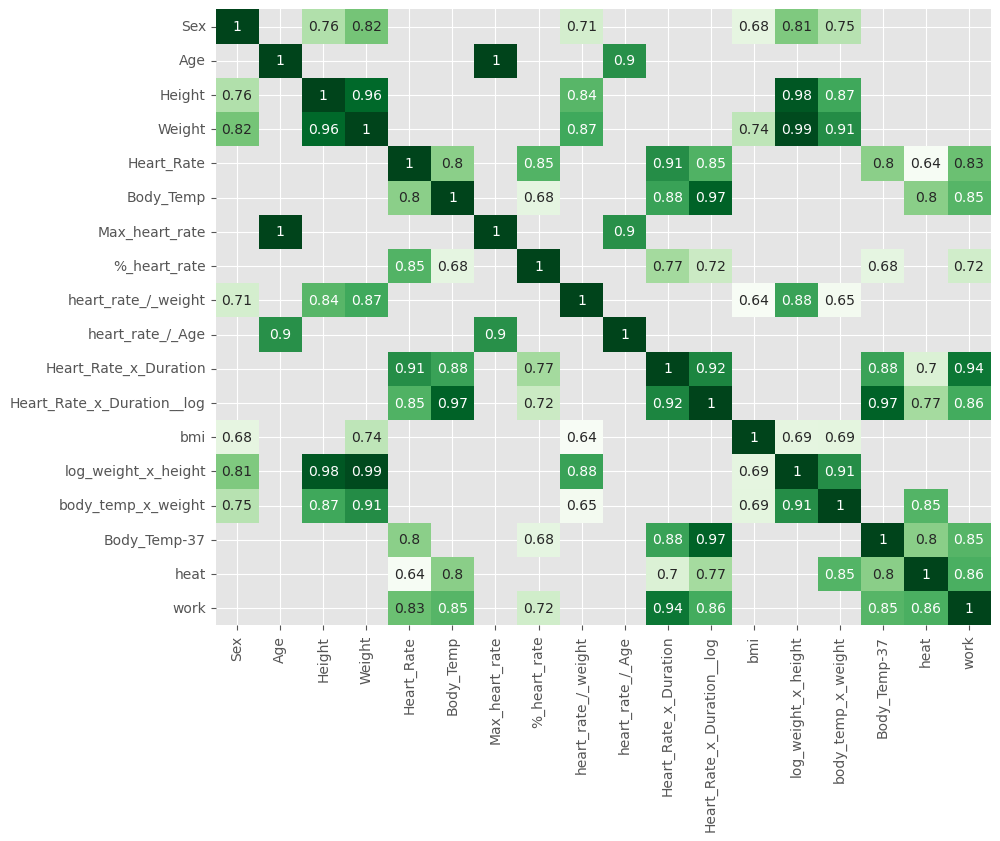

In [25]:
corr = X_train_prep.corr(numeric_only=True).abs()

corr_selected = corr.mask(((corr<0.6)|(corr>1)),float('NaN'))

plt.figure(figsize=(10,8))
sns.heatmap(corr_selected,cmap='Greens',cbar=False,annot=True)
plt.show()

<Figure size 1000x800 with 0 Axes>

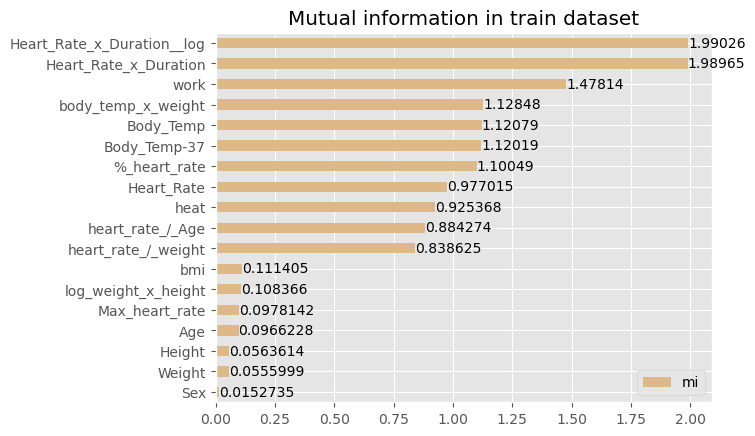

In [26]:
mi = mutual_info_regression(X_train_prep,y_train)

mi_df = pd.DataFrame({'mi':mi},index=X_train_prep.columns)

plt.figure(figsize=(10,8))
ax = mi_df.sort_values(by='mi').plot.barh(title='Mutual information in train dataset',color=chartcolor)
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [27]:
X_tr,X_va_ts,y_tr,y_va_ts = train_test_split(X_train_prep,y_train,train_size=0.6,random_state=0)
X_va,X_ts,y_va,y_ts = train_test_split(X_va_ts,y_va_ts,train_size=.5,random_state=0)
[d.shape for d in [X_tr,y_tr,X_va,y_va,X_ts,y_ts]]

[(450000, 18), (450000,), (150000, 18), (150000,), (150000, 18), (150000,)]

In [28]:
cat_params = {'iterations': 730, 
             'learning_rate': 0.09969738378973637, 
             'colsample_bylevel': 0.8121910932765485, 
             'random_strength': 0.2315038504123904, 
             'depth': 14, 
             'bootstrap_type': 'Bayesian', 
             'bagging_temperature': 0.2878598947199843}


estimators = [
              ('XGBoost', XGBRegressor(n_estimators=600, max_depth=8, verbosity=0)), 
              ('LGBM', LGBMRegressor(n_estimators=1000,max_depth=6, learning_rate=0.02, verbose=-1)), 
              ('CatBoost', CatBoostRegressor(**cat_params, verbose=0, eval_metric='RMSE')) 
]

In [29]:
for est_name, est in estimators:
    est.fit(X_tr, y_tr)
    pred = np.clip(est.predict(X_va), 0, y_train.max()) # clip to prevent negative values
    valid_rmsle = np.sqrt(mean_squared_log_error(y_va, pred))
    print(f'{est_name} valid_rmsle: {valid_rmsle:.6f}')

XGBoost valid_rmsle: 0.064521
LGBM valid_rmsle: 0.064277
CatBoost valid_rmsle: 0.062262


In [30]:
def model_features_importance(model, model_name, color):
    model = model
    model.fit(X_tr, y_tr)
    model_feat_importances = pd.DataFrame({'Features':X_tr.columns, 
                                         'Importances':model.feature_importances_}
                                       ).sort_values(by='Importances', ascending=False)

    plt.figure(figsize=(8, 4))
    ax = sns.barplot(model_feat_importances, y='Features', x='Importances', color=color)
    for label in ax.containers:
        ax.bar_label(label)
    plt.title(f'Features importance in {model_name}')
    plt.show()

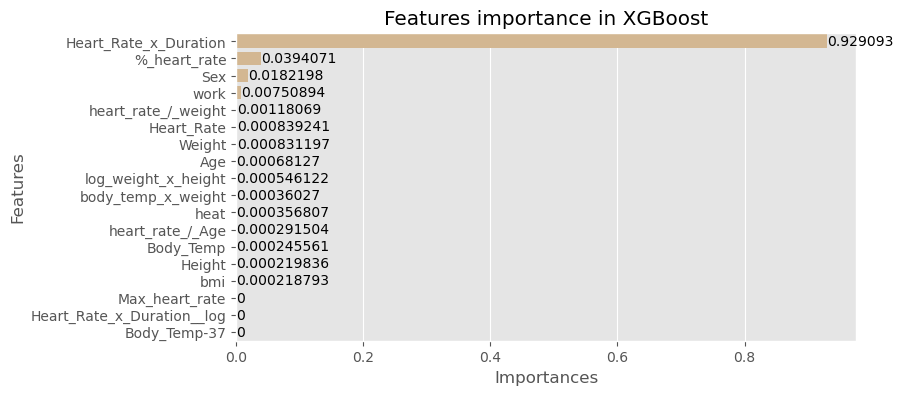

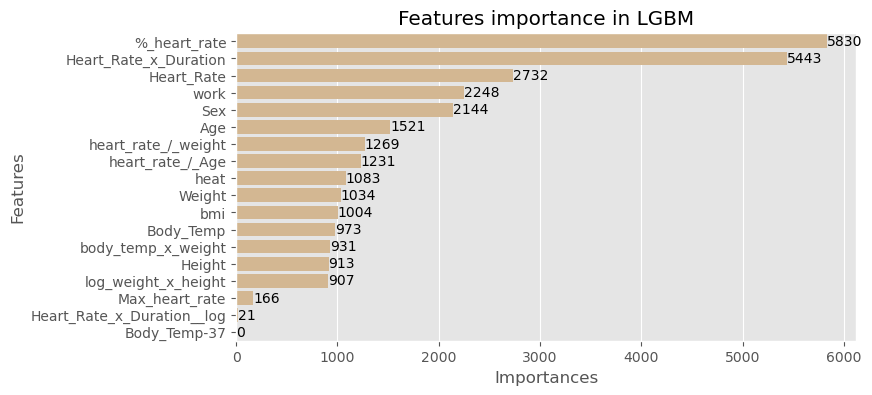

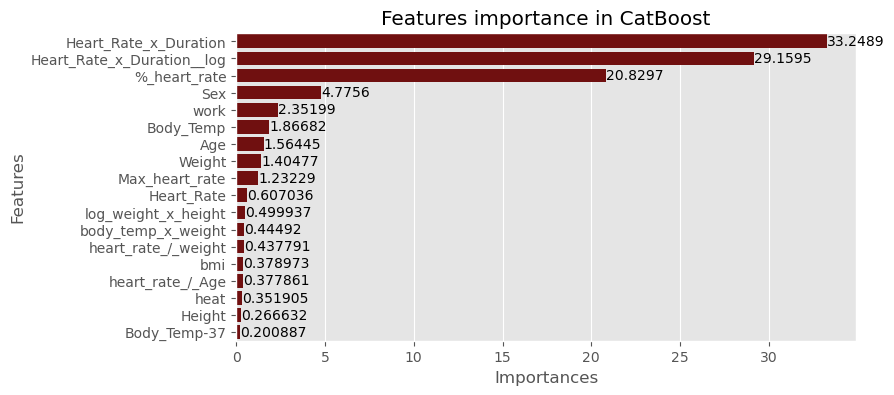

In [31]:
colors = ['green', 'orange', 'maroon', 'steelblue', chartcolor, facecolor]
for est_name, est in estimators:
    # color_ = random.shuffle(colors)
    color_ = random.choice(colors)
    model_features_importance(est, est_name, color_)

In [32]:
#時間がかかりすぎる
# def objective(trial):
#     # Sample weights for the three estimators
#     weight_xgb = trial.suggest_int('weight_xgb', 2, 8, 1)
#     weight_lgb = trial.suggest_int('weight_lgb', 0, 5, 1)
#     weight_cat = trial.suggest_int('weight_cat', 4, 12, 1)

#     # Create the Voting Regressor
#     weights=[weight_xgb, weight_lgb,  weight_cat] # The weights
    
#     vr = VotingRegressor(estimators=estimators, weights=weights, n_jobs=-1) # The voting regressor

#     # Fit the model and calculate predictions
#     vr.fit(X_tr, y_tr)
#     y_pred = vr.predict(X_va)

#     # Calculate mean squared error (you can use any other metric)
#     score = np.sqrt(mean_squared_log_error(y_va, y_pred))
#     return score


# Define the function to run optuna optimization
# def Run_Pass_cat_study(n_trials=1):
#     if n_trials>1:
#         # Optimize using Optuna
#         study = optuna.create_study(direction='minimize')
#         study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
#         # Get the best weights
#         best_weights = study.best_params
#     else:
#         print('No need to run optuna, we will use the parameters obtained earlier')
#         best_weights = {'weight_xgb': 2, 
#                              'weight_lgb': 1, 
#                              'weight_cat': 5 
#                              }

#     print('\n\nbest params: {}'.format(best_weights))
#     return best_weights

# # weights_dico = Run_Pass_cat_study(1)

# weights_list = list(Run_Pass_cat_study(25).values())

In [ ]:
def objective(trial):
    # Sample weights for the three estimators
    weight_xgb = trial.suggest_int('weight_xgb', 2, 8, 1)
    weight_lgb = trial.suggest_int('weight_lgb', 0, 5, 1)
    weight_cat = trial.suggest_int('weight_cat', 4, 12, 1)

    xgb_model = XGBRegressor(n_estimators=600, max_depth=8, verbosity=1)

    lgbm_model = LGBMRegressor(n_estimators=1000, max_depth=6, learning_rate=0.02, verbose=-1)

    cat_model = CatBoostRegressor(**cat_params, verbose=1, eval_metric='RMSE')


    # 2. モデルのセット
    estimators = [
        ('XGBoost', xgb_model),
        ('LGBM', lgbm_model),
        ('CatBoost', cat_model)
    ]

    # 重み
    weights = [weight_xgb, weight_lgb, weight_cat]
    vr = VotingRegressor(estimators=estimators, weights=weights)

    # モデルの学習
    vr.fit(X_tr, y_tr)

    # サンプルデータを使って予測のみ行う（再学習なし）
    y_pred = vr.predict(X_va_sample)
    score = np.sqrt(mean_squared_log_error(y_va_sample, y_pred))
    return score


def Run_Pass_cat_study(n_trials=1):
    if n_trials > 1:
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_weights = study.best_params
    else:
        print('No need to run optuna, we will use the parameters obtained earlier')
        best_weights = {
            'weight_xgb': 2,
            'weight_lgb': 1,
            'weight_cat': 5
        }

    print('\n\nbest params: {}'.format(best_weights))
    return best_weights


# サンプルデータ作成
# X_va と y_va のペアを同時にサンプリングしないと index がズレる
va_sample = X_va.copy()
va_sample['target'] = y_va
va_sample_sampled = va_sample.sample(frac=0.1, random_state=42)

X_va_sample = va_sample_sampled.drop(columns='target')
y_va_sample = va_sample_sampled['target']


# 実行例
weights_list = list(Run_Pass_cat_study(10).values())

[I 2025-06-17 14:14:04,343] A new study created in memory with name: no-name-bc95c2eb-0167-45e7-836a-c6d5a4bb421a


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 56.3478951	total: 210ms	remaining: 2m 33s
1:	learn: 50.8695944	total: 319ms	remaining: 1m 56s
2:	learn: 45.9213531	total: 430ms	remaining: 1m 44s
3:	learn: 41.4787019	total: 535ms	remaining: 1m 37s
4:	learn: 37.4681830	total: 623ms	remaining: 1m 30s
5:	learn: 33.8556149	total: 718ms	remaining: 1m 26s
6:	learn: 30.5954969	total: 817ms	remaining: 1m 24s
7:	learn: 27.6552904	total: 918ms	remaining: 1m 22s
8:	learn: 25.0214186	total: 1.03s	remaining: 1m 22s
9:	learn: 22.6465430	total: 1.12s	remaining: 1m 20s
10:	learn: 20.5090749	total: 1.24s	remaining: 1m 21s
11:	learn: 18.5926488	total: 1.42s	remaining: 1m 25s
12:	learn: 16.8682331	total: 1.54s	remaining: 1m 25s
13:	learn: 15.3253205	total: 1.63s	remaining: 1m 23s
14:	learn: 13.9389351	total: 1.72s	remaining: 1m 21s
15:	learn: 12.6991836	total: 1.81s	remaining: 1m 20s
16:	learn: 11.5902695	total: 1.9s	remaining: 1m 19s
17:	learn: 10.6019695	total: 2s	remaining: 1m 19s
18:	learn: 9.7194224	total: 2.1s	remaining: 1m 18s
19:	learn

In [38]:
# 最終モデルの構築
final_estimators = [
    ('XGBoost', XGBRegressor(n_estimators=600, max_depth=8, verbosity=1)),
    ('LGBM', LGBMRegressor(n_estimators=1000, max_depth=6, learning_rate=0.02, verbose=-1)),
    ('CatBoost', CatBoostRegressor(**cat_params, verbose=1, eval_metric='RMSE'))
]

# Build the voting regressor
voting_reg = VotingRegressor(final_estimators, 
                             weights=weights_list,
                             n_jobs=-1, 
                             verbose=0
                            )

# Fit the voting regressor
voting_reg.fit(X_train_prep, y_train)
# predict
y_pred = voting_reg.predict(X_test_prep)

0:	learn: 56.3231932	total: 315ms	remaining: 3m 49s
1:	learn: 50.8387538	total: 601ms	remaining: 3m 38s
2:	learn: 45.8871029	total: 787ms	remaining: 3m 10s
3:	learn: 41.4319674	total: 966ms	remaining: 2m 55s
4:	learn: 37.4187222	total: 1.12s	remaining: 2m 42s
5:	learn: 33.7966754	total: 1.29s	remaining: 2m 35s
6:	learn: 30.5392261	total: 1.47s	remaining: 2m 31s
7:	learn: 27.6029950	total: 1.66s	remaining: 2m 30s
8:	learn: 24.9686817	total: 1.84s	remaining: 2m 27s
9:	learn: 22.6019974	total: 2.03s	remaining: 2m 25s
10:	learn: 20.4652935	total: 2.2s	remaining: 2m 24s
11:	learn: 18.5435200	total: 2.4s	remaining: 2m 23s
12:	learn: 16.8268799	total: 2.57s	remaining: 2m 21s
13:	learn: 15.2815889	total: 2.73s	remaining: 2m 19s
14:	learn: 13.8946818	total: 2.9s	remaining: 2m 18s
15:	learn: 12.6551489	total: 3.08s	remaining: 2m 17s
16:	learn: 11.5501502	total: 3.26s	remaining: 2m 16s
17:	learn: 10.5630065	total: 3.45s	remaining: 2m 16s
18:	learn: 9.6813667	total: 3.66s	remaining: 2m 16s
19:	lea

In [40]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

0:	learn: 56.3289946	total: 291ms	remaining: 3m 31s
1:	learn: 50.8520504	total: 459ms	remaining: 2m 46s
2:	learn: 45.9042022	total: 616ms	remaining: 2m 29s
3:	learn: 41.4553459	total: 761ms	remaining: 2m 18s
4:	learn: 37.4433427	total: 894ms	remaining: 2m 9s
5:	learn: 33.8294183	total: 1.03s	remaining: 2m 4s
6:	learn: 30.5731266	total: 1.17s	remaining: 2m
7:	learn: 27.6352137	total: 1.35s	remaining: 2m 1s
8:	learn: 24.9959920	total: 1.53s	remaining: 2m 2s
9:	learn: 22.6263406	total: 1.67s	remaining: 2m
10:	learn: 20.4940200	total: 1.82s	remaining: 1m 58s
11:	learn: 18.5793068	total: 1.95s	remaining: 1m 56s
12:	learn: 16.8510344	total: 2.07s	remaining: 1m 54s
13:	learn: 15.3054091	total: 2.19s	remaining: 1m 51s
14:	learn: 13.9212884	total: 2.33s	remaining: 1m 50s
15:	learn: 12.6825472	total: 2.46s	remaining: 1m 49s
16:	learn: 11.5777149	total: 2.61s	remaining: 1m 49s
17:	learn: 10.5871716	total: 2.74s	remaining: 1m 48s
18:	learn: 9.7059804	total: 2.97s	remaining: 1m 51s
19:	learn: 8.922

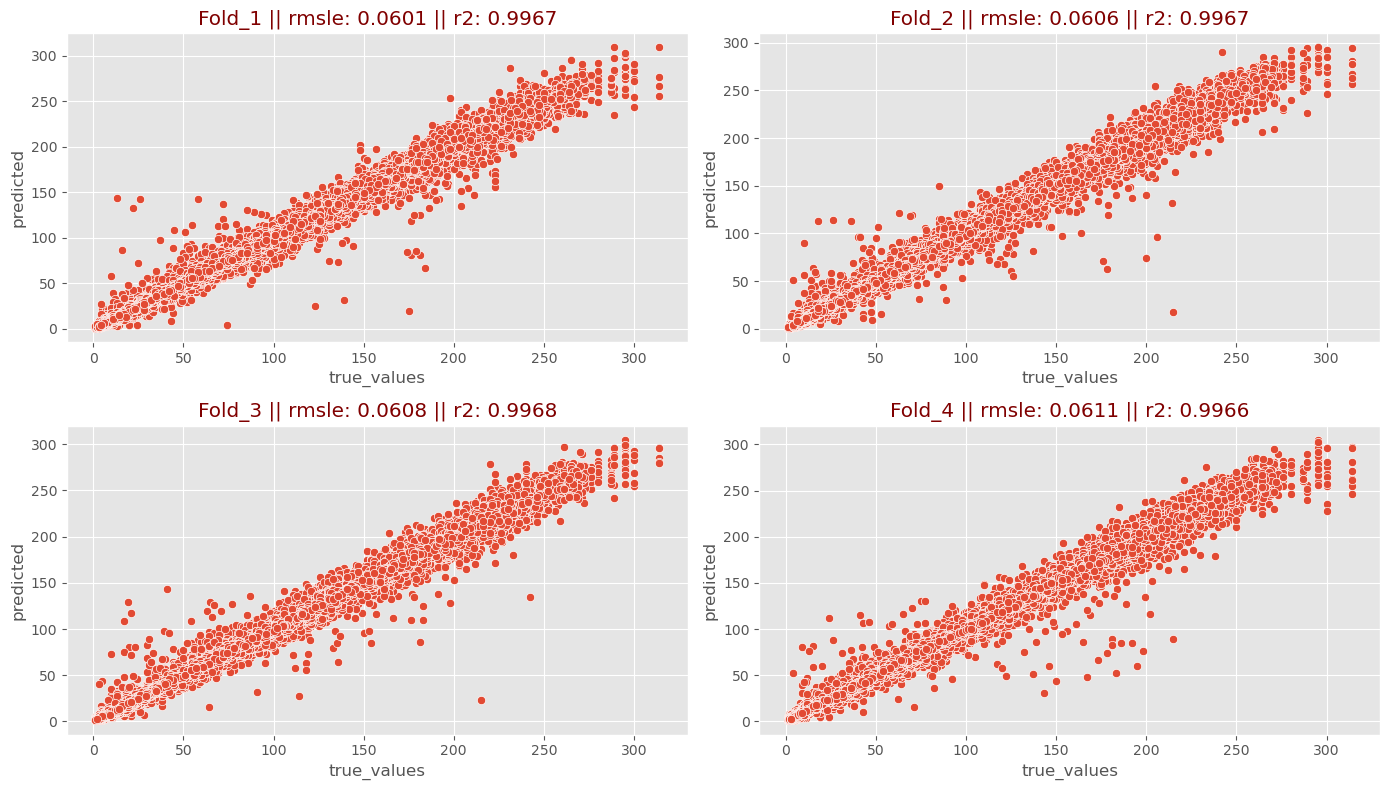

In [41]:
spliter = KFold(n_splits=4, shuffle=True, random_state=15)

plt.figure(figsize=(14,8))
for f, (tr_ind, va_ind) in enumerate(spliter.split(X_train_prep, y_train), start=1):
    X_tr, X_va = X_train_prep.loc[tr_ind], X_train_prep.loc[va_ind]
    y_tr, y_va = y_train.loc[tr_ind], y_train.loc[va_ind]
    # fit and predict for the fold
    reg = voting_reg.fit(X_tr, y_tr)
    y_va_hat = reg.predict(X_va)
    y_va_hat = np.clip(y_va_hat, train_raw[target].min(), train_raw[target].max())
    # score the prediction for the fold
    rmsle_score = rmsle(y_va, y_va_hat)
    r2 = r2_score(y_va, y_va_hat)
    # plot a scatter plot to compare predicted vs true values
    plt.subplot(2,2,f)
    sns.scatterplot(x=y_va, y=y_va_hat)
    plt.title(f"Fold_{f} || rmsle: {rmsle_score:.4f} || r2: {r2:.4}", color='maroon')
    plt.xlabel('true_values')
    plt.ylabel('predicted')
plt.tight_layout()
plt.show()

In [42]:
model = voting_reg

model.fit(X_train_prep, y_train)

pred_base = model.predict(X_test_prep)

sub_base = sample_submission.copy()

sub_base[target] = pred_base

sub_base.to_csv('submission2.csv', index=False)

pd.read_csv('submission2.csv')

0:	learn: 56.3231932	total: 351ms	remaining: 4m 16s
1:	learn: 50.8387538	total: 538ms	remaining: 3m 15s
2:	learn: 45.8871029	total: 695ms	remaining: 2m 48s
3:	learn: 41.4319674	total: 844ms	remaining: 2m 33s
4:	learn: 37.4187222	total: 991ms	remaining: 2m 23s
5:	learn: 33.7966754	total: 1.15s	remaining: 2m 18s
6:	learn: 30.5392261	total: 1.29s	remaining: 2m 12s
7:	learn: 27.6029950	total: 1.45s	remaining: 2m 10s
8:	learn: 24.9686817	total: 1.64s	remaining: 2m 11s
9:	learn: 22.6019974	total: 1.81s	remaining: 2m 10s
10:	learn: 20.4652935	total: 1.98s	remaining: 2m 9s
11:	learn: 18.5435200	total: 2.14s	remaining: 2m 7s
12:	learn: 16.8268799	total: 2.29s	remaining: 2m 6s
13:	learn: 15.2815889	total: 2.5s	remaining: 2m 7s
14:	learn: 13.8946818	total: 2.71s	remaining: 2m 9s
15:	learn: 12.6551489	total: 2.87s	remaining: 2m 7s
16:	learn: 11.5501502	total: 3.02s	remaining: 2m 6s
17:	learn: 10.5630065	total: 3.17s	remaining: 2m 5s
18:	learn: 9.6813667	total: 3.31s	remaining: 2m 3s
19:	learn: 8.9

,id,Calories
0,750000,27.534589
1,750001,108.156150
2,750002,87.074819
3,750003,125.640243
4,750004,75.751913
...,...,...
249995,999995,26.159972
249996,999996,9.182692
249997,999997,73.430099
249998,999998,168.843539
